In [1]:
from functions.data_by_country import data_by_country
from utils.data_loader import load_data_parquet
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = load_data_parquet()
df.dtypes

TypeError: read_table() got an unexpected keyword argument 'parse_dates'

In [3]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [7]:
df = data_by_country(df)
df = df.pivot(index="dt", columns="Country",
              values='AverageTemperature').dropna()

# %%
data = df.loc["2013-01-01"] - df.loc["1889-01-01"]
data = data.sort_values()

In [8]:
df.head()

Country,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,...,United Arab Emirates,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
dt,,,,,,,,,,,,,,,,,,,,,
1889-01-01,-0.846500,6.385,7.5450,21.919667,22.189875,-8.358,21.312643,-5.3752,-5.638,21.138,...,17.736,2.972824,4.487132,23.2405,-7.520000,24.267875,20.540767,21.9845,21.410000,21.731000
1889-02-01,3.470750,7.788,9.4150,23.449500,21.372594,0.215,21.316214,-4.5182,2.678,21.024,...,19.530,2.784412,4.292914,22.3060,1.402375,25.611100,21.295000,23.3795,22.425625,22.182429
1889-03-01,10.034750,9.429,10.6694,23.948000,20.196375,3.494,20.540000,-1.6404,4.123,21.309,...,23.544,4.518265,9.722374,21.7315,7.620500,26.256500,23.491267,25.2175,22.149250,21.482857
1889-04-01,14.629125,12.941,13.9796,23.168833,15.165281,8.170,17.976429,5.2978,9.007,23.535,...,25.658,6.624088,14.217393,16.3245,13.722500,26.777500,26.052633,26.4165,21.149125,20.229857
1889-05-01,18.418000,18.344,19.0428,22.091333,12.777563,13.362,15.788714,14.1070,15.422,25.582,...,29.745,12.425809,17.799755,14.0500,16.930125,26.982700,28.123367,28.3395,19.288125,18.013571


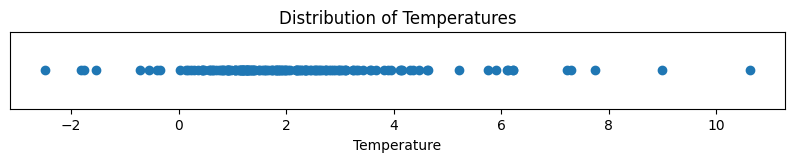

In [5]:
plt.figure(figsize=(10, 1))
plt.scatter(data, [1]*len(data), marker='o')
plt.yticks([])  # Hide y-axis ticks
plt.title('Distribution of Temperatures')
plt.xlabel('Temperature')
plt.show()